In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from ipywidgets import interact, widgets
from IPython.display import display, clear_output
import plotly.graph_objects as go
import folium

In [3]:
final_data = pd.read_csv('data/final_data.csv')

In [4]:
final_data.head()

,year,life_ladder,log_gdp_per_capita,social_suppoprt,healthy_life_exp_at_birth,freedom_to_make_life_choices,generosity,perceptions_of_corruption,positive_affect,negative_affect,pop_density,suicide_rate,country,region,continent,PC1,PC2,PC3
0,2008.0,3.724,7.370,0.451,50.80,0.718,0.168,0.882,0.518,0.258,40.518221,4.6,Afghanistan,Southern Asia,Asia,-3.904024,1.522443,-0.392721
1,2009.0,4.402,7.540,0.552,51.20,0.679,0.190,0.850,0.584,0.237,41.987193,4.4,Afghanistan,Southern Asia,Asia,-3.042211,1.530975,-0.034099
2,2010.0,4.758,7.647,0.539,51.60,0.600,0.121,0.707,0.618,0.275,43.220447,4.3,Afghanistan,Southern Asia,Asia,-2.921751,1.411316,-0.408508
3,2011.0,3.832,7.620,0.521,51.92,0.496,0.162,0.731,0.611,0.267,44.844851,4.1,Afghanistan,Southern Asia,Asia,-3.562986,1.331637,-0.497841
4,2012.0,3.783,7.705,0.521,52.24,0.531,0.236,0.776,0.710,0.268,46.711251,4.0,Afghanistan,Southern Asia,Asia,-3.194194,1.870484,-0.097930


In [5]:
final_data.shape

(1910, 18)

### Clustering

Since we want to cluster all of the points at once, before filtering by year, in order to see the countries 'progress' between clusters throughout the years, we have a lot of points to cluster at once. To make the clustering more efficient we will use **Bisecting K-means** technique, which is based on hierarchical tree structure and top-down separation approach and this should be more efficient in dealing with large datasets that are difficult to cluster.



In [6]:
from sklearn.cluster import BisectingKMeans
from sklearn.metrics import silhouette_score

In [7]:
X = np.array([final_data['PC1'],final_data['PC2'],final_data['PC3']]).T

In [8]:
X.shape

(1910, 3)

In [9]:
range_n_clusters = list(range(2, 15))

wcss = [] #Within cluster sum of squares

#Calculating silhouette scores for different numbers of clusters
for n_clusters in range_n_clusters:
    kmeans = BisectingKMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X)
    wcss.append(kmeans.inertia_)

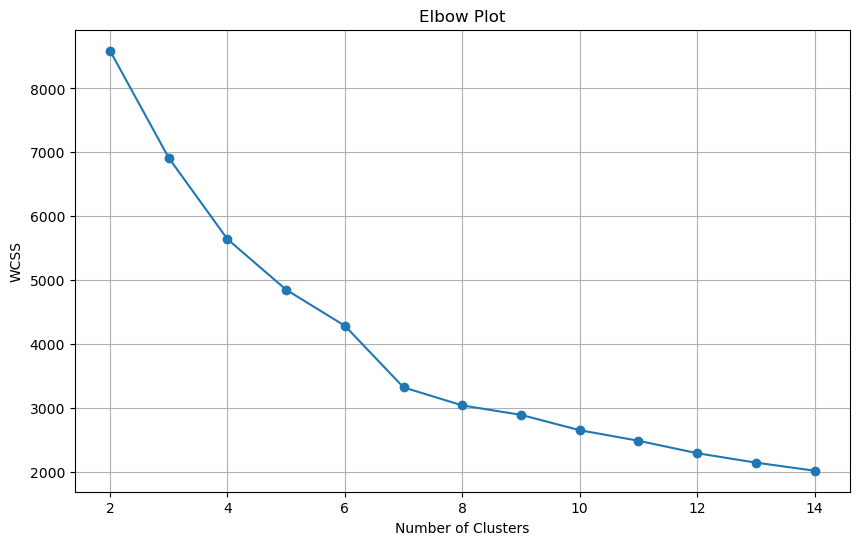

In [10]:
#Plotting the elbow plot
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, wcss, marker='o')
plt.title("Elbow Plot")
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")
plt.grid(True)
plt.show()

In [11]:
bisect_means = BisectingKMeans(n_clusters=5, random_state=42).fit(X)

In [12]:
cluster_data = final_data.copy()

cluster_data['cluster'] = bisect_means.labels_.astype(str)

In [13]:
cluster_data.head()

,year,life_ladder,log_gdp_per_capita,social_suppoprt,healthy_life_exp_at_birth,freedom_to_make_life_choices,generosity,perceptions_of_corruption,positive_affect,negative_affect,pop_density,suicide_rate,country,region,continent,PC1,PC2,PC3,cluster
0,2008.0,3.724,7.370,0.451,50.80,0.718,0.168,0.882,0.518,0.258,40.518221,4.6,Afghanistan,Southern Asia,Asia,-3.904024,1.522443,-0.392721,0
1,2009.0,4.402,7.540,0.552,51.20,0.679,0.190,0.850,0.584,0.237,41.987193,4.4,Afghanistan,Southern Asia,Asia,-3.042211,1.530975,-0.034099,0
2,2010.0,4.758,7.647,0.539,51.60,0.600,0.121,0.707,0.618,0.275,43.220447,4.3,Afghanistan,Southern Asia,Asia,-2.921751,1.411316,-0.408508,0
3,2011.0,3.832,7.620,0.521,51.92,0.496,0.162,0.731,0.611,0.267,44.844851,4.1,Afghanistan,Southern Asia,Asia,-3.562986,1.331637,-0.497841,0
4,2012.0,3.783,7.705,0.521,52.24,0.531,0.236,0.776,0.710,0.268,46.711251,4.0,Afghanistan,Southern Asia,Asia,-3.194194,1.870484,-0.097930,0


In [14]:
def interactive_plot_scatter1(year, x_axis, y_axis, ignore_year):
    
    if ignore_year:
        filtered_data = cluster_data
        print(f"All data points")
    else:
        # Filter the data for the selected year
        filtered_data = cluster_data[cluster_data['year'] == year]
        print(f"{filtered_data.shape[0]} countries for the year {year}")

    filtered_data = filtered_data.sort_values(by=['cluster'])

    #Define a fixed color scheme for clusters
    color_map = {
        '0': '#228B22', 
        '1': '#00BFFF',    
        '2': '#FFD700',  
        '3': '#DC143C',
        '4': '#7851A9'
    }

    #Create the plot
    fig = px.scatter(filtered_data, x=x_axis, y=y_axis, color='cluster', 
                     range_x = [np.min(cluster_data[x_axis]-0.5), np.max(cluster_data[x_axis])+0.5],
                     range_y = [np.min(cluster_data[y_axis]-0.5), np.max(cluster_data[y_axis])+0.5],
                     hover_name='country', color_discrete_map=color_map)

    fig.update_layout(
        plot_bgcolor='white', 
        width=1000,  
        height=700,  
        legend=dict(
            orientation="h", 
            yanchor="bottom",
            y=-0.15,  
            xanchor="center",
            x=0.5
        ),
        xaxis=dict(
            showgrid=True,  
            gridcolor='LightGrey',
            zeroline=True,  
            zerolinecolor='LightGrey', 
            zerolinewidth=1
        ),
        yaxis=dict(
            showgrid=True, 
            gridcolor='LightGrey',
            zeroline=True, 
            zerolinecolor='LightGrey',  
            zerolinewidth=1
        )
    )
    
    fig.show()

In [15]:
index_life_ladder = cluster_data.columns.get_loc('life_ladder')
index_country = cluster_data.columns.get_loc('country')
index_PC1 = cluster_data.columns.get_loc('PC1')
index_PC3 = cluster_data.columns.get_loc('PC3')

plotting_variables = cluster_data.columns[index_life_ladder:index_country].tolist() + cluster_data.columns[index_PC1:index_PC3+1].tolist()

In [16]:
#Slider for year selection
year_slider = widgets.IntSlider(value=2019, min=cluster_data['year'].min(), max=cluster_data['year'].max(), step=1, description='Year:')
ignore_year_checkbox = widgets.Checkbox(value=False, description='Ignore Year Filter', disabled=False)

#Dropdown for selecting x and y axis variables
variables = plotting_variables 
x_axis_dropdown = widgets.Dropdown(options=variables, value='PC1', description='X Axis:')
y_axis_dropdown = widgets.Dropdown(options=variables, value='PC2', description='Y Axis:')

#Display the interactive widgets
interact(interactive_plot_scatter1, year=year_slider, x_axis=x_axis_dropdown, y_axis=y_axis_dropdown, ignore_year=ignore_year_checkbox)

interactive(children=(IntSlider(value=2019, description='Year:', max=2020, min=2005), Dropdown(description='X …

<function __main__.interactive_plot_scatter1(year, x_axis, y_axis, ignore_year)>

In [17]:
#Define a function to assign unique colors
def get_unique_colors(n):
    return px.colors.qualitative.Plotly[:n]

In [18]:
def interactive_plot_scatter2(year, x_axis, y_axis, selected_countries):
    
    filtered_data = cluster_data[cluster_data['year'] <= year]
    print(f"{len(filtered_data[filtered_data['year'] == year])} data points from year {year}")

    filtered_data = filtered_data.sort_values(by=['cluster'])
    
    #Define a fixed color scheme for clusters
    color_map = {
        '0': '#228B22', 
        '1': '#00BFFF',    
        '2': '#FFD700',  
        '3': '#DC143C',
        '4': '#7851A9'
    }

    #Assign unique colors for each selected country
    unique_colors = get_unique_colors(len(selected_countries))

    #Scatter plot
    fig = px.scatter(filtered_data[filtered_data['year'] == year], 
                 x=x_axis, y=y_axis, color='cluster', 
                 range_x = [np.min(cluster_data[x_axis])-0.5, np.max(cluster_data[x_axis])+0.5],
                 range_y = [np.min(cluster_data[y_axis])-0.5, np.max(cluster_data[y_axis])+0.5],
                 hover_name='country',  # Set hover name to 'country'
                 hover_data={'country': False, x_axis: False, y_axis: False},  # Include only country in hover data
                 opacity=0.4 if selected_countries else 1,  # Adjust opacity
                 color_discrete_map=color_map)

    fig.update_traces(hovertemplate='%{hovertext}')

    #Add lines and points for selected countries
    for i, country in enumerate(selected_countries):
        country_data = filtered_data[filtered_data['country'] == country]
        country_color = unique_colors[i % len(unique_colors)]
        
        #Add line trace for each country
        line_trace = px.line(country_data, x=x_axis, y=y_axis, 
                             color_discrete_sequence=[country_color],
                             hover_name='country', hover_data=['year']).data[0]
        line_trace.name = country  # Assign country name to the line trace for the legend
        line_trace.hovertemplate = f"{country}<br>%{{y}}<extra></extra>"  # Custom hover template
        
        fig.add_trace(line_trace)
    
        #Add scatter trace for points on the line
        point_trace = px.scatter(country_data, x=x_axis, y=y_axis, 
                                 color_discrete_sequence=[country_color], 
                                 hover_name='year', hover_data=['country']).data[0]
        point_trace.hovertemplate = f"%{{hovertext}}<extra>{country}</extra>"  # Custom hover template
    
        fig.add_trace(point_trace)


    #Update layout of the plot
    fig.update_layout(
        plot_bgcolor='white', 
        width=1000,  
        height=700,  
        legend=dict(
            orientation="h", 
            yanchor="bottom",
            y=-0.15,  
            xanchor="center",
            x=0.5
        ),
        xaxis=dict(
            showgrid=True,
            gridcolor='LightGrey',
            zeroline=True,
            zerolinecolor='LightGrey',
            zerolinewidth=1
        ),
        yaxis=dict(
            showgrid=True,
            gridcolor='LightGrey',
            zeroline=True,
            zerolinecolor='LightGrey',
            zerolinewidth=1
        )
    )
    
    fig.show()

#Widgets
year_slider = widgets.IntSlider(value=2019, min=cluster_data['year'].min(), max=cluster_data['year'].max(), step=1, description='Year:')
country_selection = widgets.SelectMultiple(options=cluster_data['country'].unique(), value=[], description='Countries', disabled=False)

#Dropdown
variables = plotting_variables
x_axis_dropdown = widgets.Dropdown(options=variables, value='PC1', description='X Axis:')
y_axis_dropdown = widgets.Dropdown(options=variables, value='PC2', description='Y Axis:')

interact(interactive_plot_scatter2, year=year_slider, x_axis=x_axis_dropdown, y_axis=y_axis_dropdown, selected_countries=country_selection)

interactive(children=(IntSlider(value=2019, description='Year:', max=2020, min=2005), Dropdown(description='X …

<function __main__.interactive_plot_scatter2(year, x_axis, y_axis, selected_countries)>

In [19]:
cluster_data.head()

,year,life_ladder,log_gdp_per_capita,social_suppoprt,healthy_life_exp_at_birth,freedom_to_make_life_choices,generosity,perceptions_of_corruption,positive_affect,negative_affect,pop_density,suicide_rate,country,region,continent,PC1,PC2,PC3,cluster
0,2008.0,3.724,7.370,0.451,50.80,0.718,0.168,0.882,0.518,0.258,40.518221,4.6,Afghanistan,Southern Asia,Asia,-3.904024,1.522443,-0.392721,0
1,2009.0,4.402,7.540,0.552,51.20,0.679,0.190,0.850,0.584,0.237,41.987193,4.4,Afghanistan,Southern Asia,Asia,-3.042211,1.530975,-0.034099,0
2,2010.0,4.758,7.647,0.539,51.60,0.600,0.121,0.707,0.618,0.275,43.220447,4.3,Afghanistan,Southern Asia,Asia,-2.921751,1.411316,-0.408508,0
3,2011.0,3.832,7.620,0.521,51.92,0.496,0.162,0.731,0.611,0.267,44.844851,4.1,Afghanistan,Southern Asia,Asia,-3.562986,1.331637,-0.497841,0
4,2012.0,3.783,7.705,0.521,52.24,0.531,0.236,0.776,0.710,0.268,46.711251,4.0,Afghanistan,Southern Asia,Asia,-3.194194,1.870484,-0.097930,0


In [20]:
cluster_data_lineplot = cluster_data.copy()

cluster_data_lineplot['cluster'] = cluster_data_lineplot['cluster'].astype(int)

In [21]:
def interactive_plot_line(selected_countries):
    
    #Define the default x-axis range
    x_range = [np.min(cluster_data_lineplot['year'])-0.5, np.max(cluster_data_lineplot['year'])]

    #Define default range for y-axis
    y_range = [-0.25, 4.25]
    if selected_countries:
        filtered_data = cluster_data_lineplot[cluster_data_lineplot['country'].isin(selected_countries)]
        y_range = [-0.25, 4.25]


    fig = px.line()

    if selected_countries:
        
        unique_colors = get_unique_colors(len(selected_countries))

        #Add lines for each selected country
        for i, country in enumerate(selected_countries):
            country_data = filtered_data[filtered_data['country'] == country]
            country_color = unique_colors[i % len(unique_colors)]

            #Add line trace for each country
            fig.add_trace(px.line(country_data, x="year", y="cluster",
                                  color_discrete_sequence=[country_color],
                                  hover_name="country").data[0])

            #Manually add legend entries
            fig.data[-1].name = country  #Name of the last trace added
            fig.data[-1].showlegend = True  

  
    fig.update_layout(
        plot_bgcolor='white', 
        width=1000,  
        height=700,
        showlegend=True,  
        legend=dict(
            title="Country",  
            orientation="h", 
            yanchor="bottom",
            y=-0.15, 
            xanchor="center",
            x=0.5
        ),
        title={
            'text': "Cluster Changes Over Years by Country",
            'y':0.95,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'
        },
        yaxis=dict(
            tickvals=[0, 1, 2, 3, 4],  #Set tick values for y-axis
            range=y_range,  #Set range for y-axis
            showgrid=True,
            gridcolor='LightGrey',
            zeroline=True,
            zerolinecolor='LightGrey',
            zerolinewidth=1
        ),
        xaxis=dict(
            range=x_range  
        )
    )
    
    fig.show()

country_selection = widgets.SelectMultiple(options=cluster_data_lineplot['country'].unique(), 
                                           value=[], 
                                           description='Countries', 
                                           disabled=False)

interact(interactive_plot_line, selected_countries=country_selection)

interactive(children=(SelectMultiple(description='Countries', options=('Afghanistan', 'Albania', 'Algeria', 'A…

<function __main__.interactive_plot_line(selected_countries)>

In [22]:
#Cluster averages

index_life_ladder = cluster_data.columns.get_loc('life_ladder')
index_suicide_rate = cluster_data.columns.get_loc('suicide_rate')
index_cluster = cluster_data.columns.get_loc('cluster')

variables = cluster_data.columns[index_life_ladder:index_suicide_rate+1].tolist() + cluster_data.columns[index_cluster:].tolist()

averages = cluster_data.loc[:,variables].groupby(['cluster']).mean()

In [23]:
averages.head()

,life_ladder,log_gdp_per_capita,social_suppoprt,healthy_life_exp_at_birth,freedom_to_make_life_choices,generosity,perceptions_of_corruption,positive_affect,negative_affect,pop_density,suicide_rate
cluster,,,,,,,,,,,
0,4.356959,7.912637,0.690810,54.325539,0.695065,0.044776,0.783795,0.680886,0.289662,135.759848,6.906523
1,4.904805,9.366338,0.780517,63.495115,0.633498,-0.116300,0.830600,0.614119,0.311735,111.782855,9.743553
2,6.003703,9.608422,0.866013,66.178973,0.806623,0.011954,0.772902,0.794778,0.255961,134.292978,7.325918
3,5.965955,10.319293,0.897115,68.773686,0.738010,-0.115113,0.822663,0.688331,0.241456,128.646973,19.124592
4,7.042071,10.815915,0.925322,71.277289,0.904129,0.173627,0.426903,0.799038,0.217169,787.295287,11.809247


In [24]:
cluster_data_filter = cluster_data[variables]

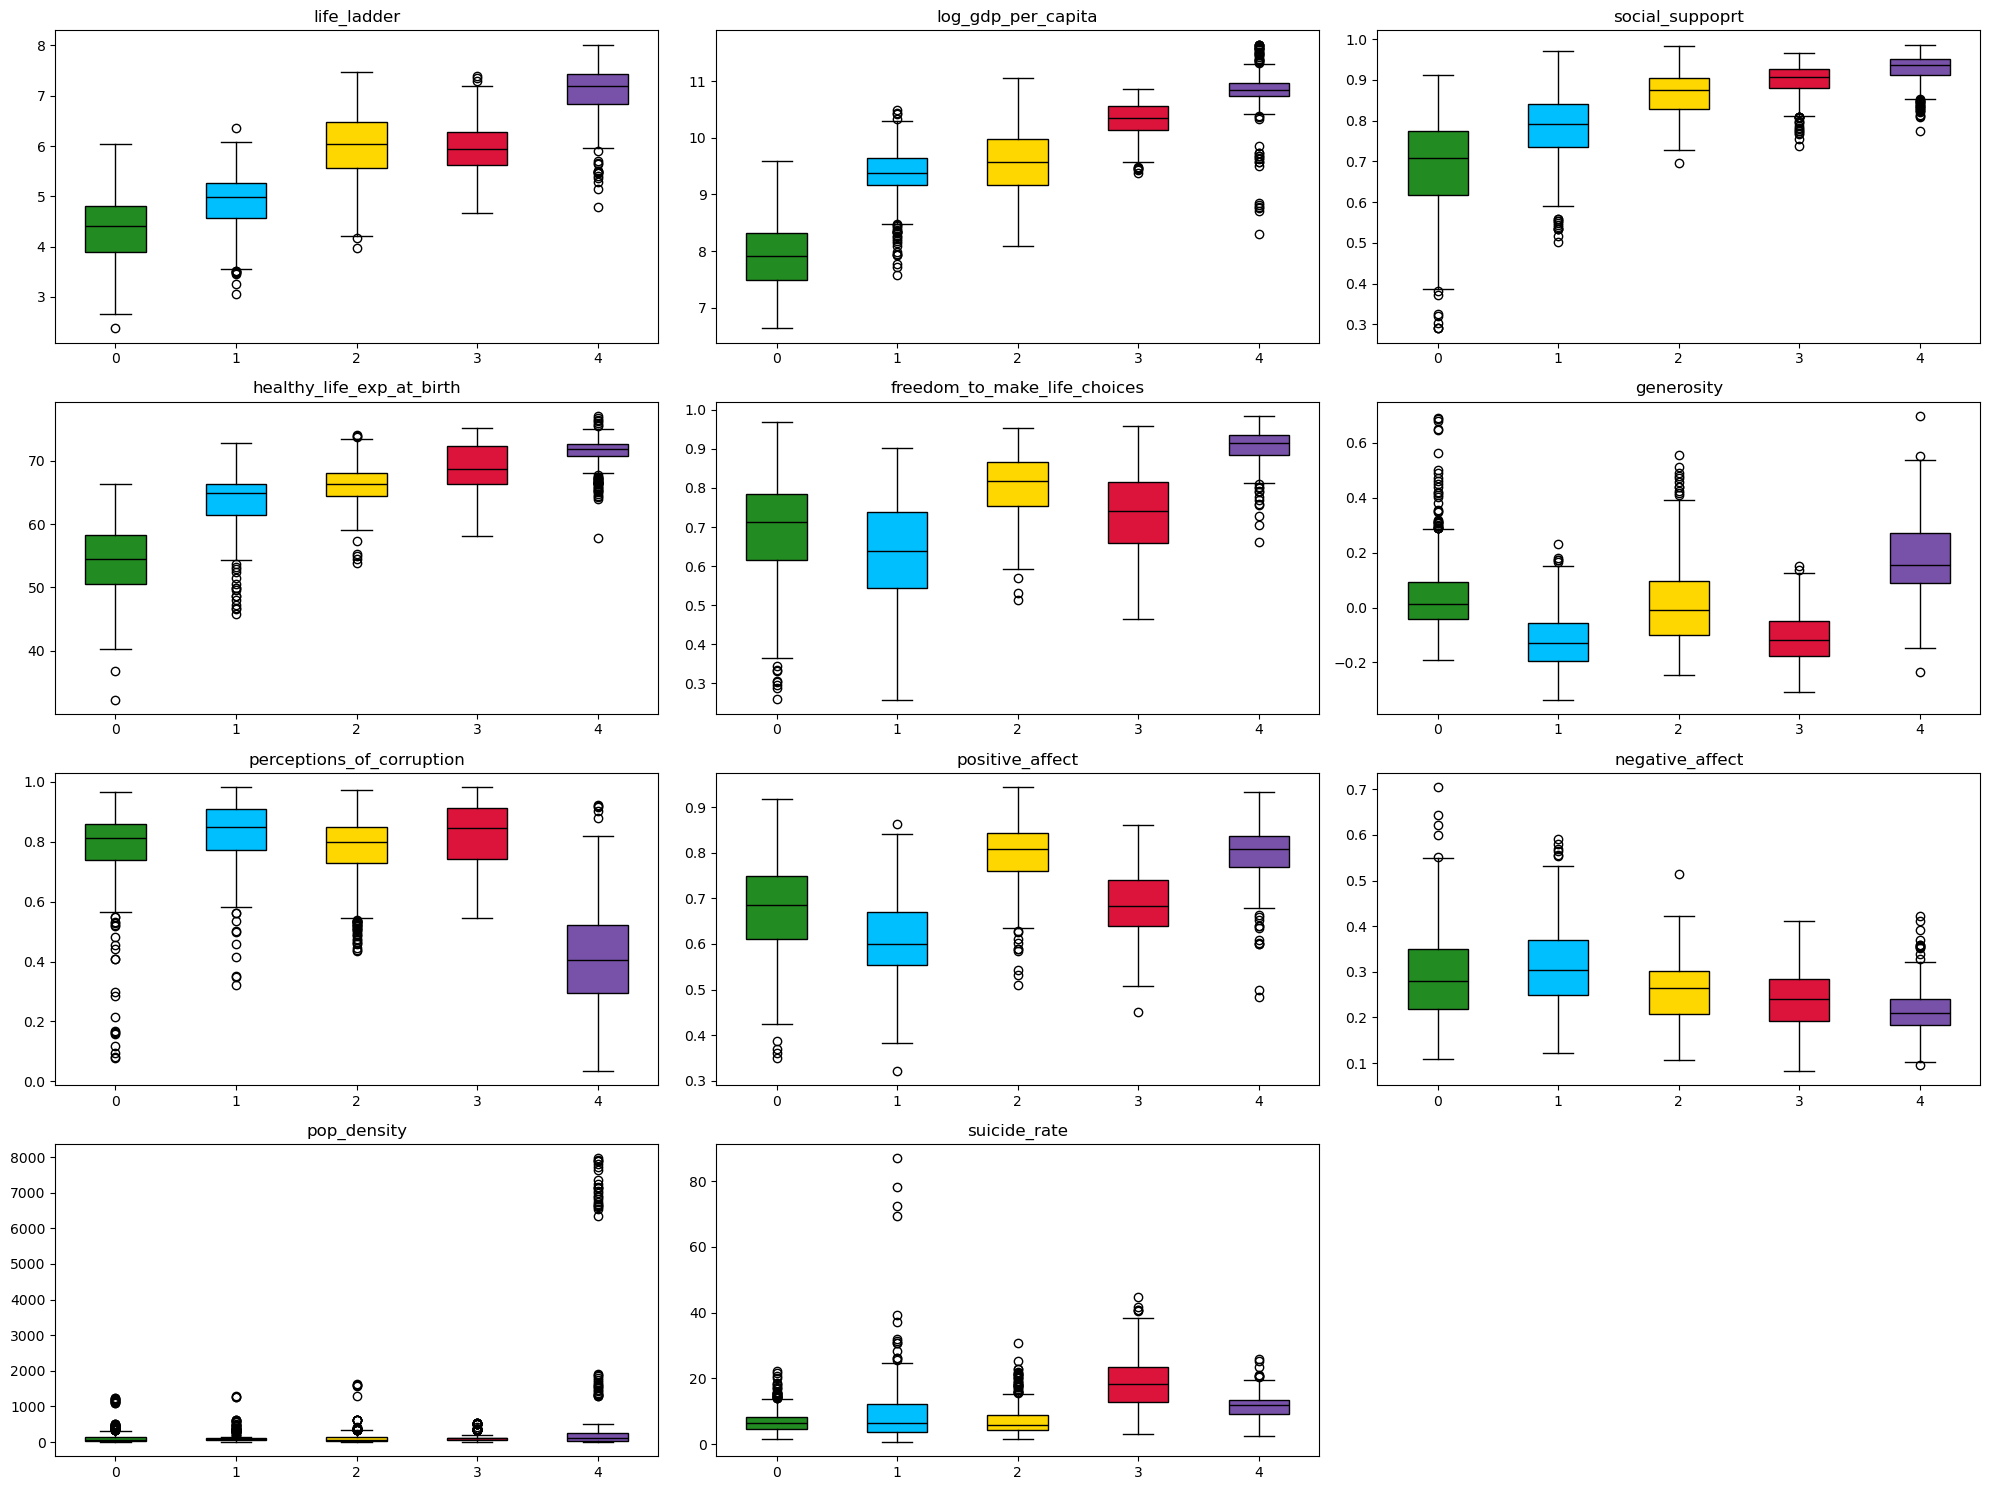

In [25]:
plt.figure(figsize=(20, 15))

color_map = {
        '0': '#228B22', 
        '1': '#00BFFF',    
        '2': '#FFD700',  
        '3': '#DC143C',
        '4': '#7851A9'}

#Iterate through each column except 'cluster' to create a boxplot
for i, column in enumerate(cluster_data_filter.columns[:-1], 1):
    plt.subplot(4, 3, i)
    
    #Create a list of data for each cluster for the current column
    data_to_plot = [cluster_data_filter[cluster_data_filter['cluster'] == cluster][column] for cluster in ['0', '1', '2', '3', '4']]

    bp = plt.boxplot(data_to_plot, patch_artist=True)

    #Setting the colors for each boxplot
    for patch, color in zip(bp['boxes'], color_map.values()):
        patch.set_facecolor(color)

    #Changing the color of the median line
    for median in bp['medians']:
        median.set_color('black')
        median.set_linewidth(1)

    plt.title(column)
    plt.xticks(ticks=[1, 2, 3, 4, 5], labels=[str(x) for x in color_map.keys()])  
    plt.xlim(0.5, 5.5) 

plt.tight_layout()
plt.show()

In [26]:
index_year = cluster_data.columns.get_loc('year')
index_country = cluster_data.columns.get_loc('country')
index_cluster = cluster_data.columns.get_loc('cluster')

variables_year = cluster_data.columns[index_year:index_country+1].tolist() + cluster_data.columns[index_cluster:].tolist()

cluster_data_filter_year = cluster_data[variables_year]

In [27]:
cluster_data_filter_year.head()

,year,life_ladder,log_gdp_per_capita,social_suppoprt,healthy_life_exp_at_birth,freedom_to_make_life_choices,generosity,perceptions_of_corruption,positive_affect,negative_affect,pop_density,suicide_rate,country,cluster
0,2008.0,3.724,7.370,0.451,50.80,0.718,0.168,0.882,0.518,0.258,40.518221,4.6,Afghanistan,0
1,2009.0,4.402,7.540,0.552,51.20,0.679,0.190,0.850,0.584,0.237,41.987193,4.4,Afghanistan,0
2,2010.0,4.758,7.647,0.539,51.60,0.600,0.121,0.707,0.618,0.275,43.220447,4.3,Afghanistan,0
3,2011.0,3.832,7.620,0.521,51.92,0.496,0.162,0.731,0.611,0.267,44.844851,4.1,Afghanistan,0
4,2012.0,3.783,7.705,0.521,52.24,0.531,0.236,0.776,0.710,0.268,46.711251,4.0,Afghanistan,0


In [28]:
variable_selector = widgets.Dropdown(
    options=list(cluster_data_filter_year.columns[1:-2]),
    description='Variable:',
    disabled=False,
    value='life_ladder'  
)

#Checkbox to ignore year
ignore_year_checkbox = widgets.Checkbox(
    value=True,
    description='Ignore Year',
    disabled=False,
    indent=False
)

#Year slider
year_slider = widgets.IntSlider(
    value=cluster_data_filter_year['year'].min(),
    min=cluster_data_filter_year['year'].min(),
    max=cluster_data_filter_year['year'].max(),
    step=1,
    description='Year:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
)

output = widgets.Output()

color_map = {
    '0': '#228B22', 
    '1': '#00BFFF',    
    '2': '#FFD700',  
    '3': '#DC143C',
    '4': '#7851A9'
}

#Function to update plot
def update_plot(variable, ignore_year, selected_year):
    with output:
        clear_output(wait=True)  #Clear the existing plot
        if ignore_year:
            filtered_data = cluster_data_filter_year
        else:
            filtered_data = cluster_data_filter_year[cluster_data_filter_year['year'] == selected_year]

        data_to_plot = [filtered_data[filtered_data['cluster'] == cluster][variable] for cluster in ['0', '1', '2', '3', '4']]
        
        fig = go.Figure()
        
        for i in ['0', '1', '2', '3', '4']:
            cluster_data = filtered_data[filtered_data['cluster'] == i]
            fig.add_trace(go.Box(
                y=cluster_data[variable],
                name=i,
                marker_color=color_map[i],
                boxpoints='outliers',  #Display outliers
                text=cluster_data['country'], 
                hoverinfo='text'  
            ))
            
        fig.update_layout(
            title={
                'text': f'{variable}',
                'y':0.9,
                'x':0.5,
                'xanchor': 'center',
                'yanchor': 'top'
            },
            showlegend=False,
            plot_bgcolor='white',
            height=600  
        )
        fig.show()

#Interactivity
def on_value_change(change):
    with output:
        update_plot(variable_selector.value, ignore_year_checkbox.value, year_slider.value)

variable_selector.observe(on_value_change, names='value')
ignore_year_checkbox.observe(on_value_change, names='value')
year_slider.observe(on_value_change, names='value')

display(variable_selector, ignore_year_checkbox, year_slider, output)

update_plot(variable_selector.value, ignore_year_checkbox.value, year_slider.value)


Dropdown(description='Variable:', options=('life_ladder', 'log_gdp_per_capita', 'social_suppoprt', 'healthy_li…

Checkbox(value=True, description='Ignore Year', indent=False)

IntSlider(value=2005, continuous_update=False, description='Year:', max=2020, min=2005)

Output()

### Cluster map

In [29]:
import geopandas as gpd

updated_geodata = gpd.read_file('data/updated_geodata.shp')

In [30]:
updated_geodata.dtypes

country        object
continent      object
region         object
geometry     geometry
dtype: object

In [31]:
cluster_data_filter_year.dtypes

year                            float64
life_ladder                     float64
log_gdp_per_capita              float64
social_suppoprt                 float64
healthy_life_exp_at_birth       float64
freedom_to_make_life_choices    float64
generosity                      float64
perceptions_of_corruption       float64
positive_affect                 float64
negative_affect                 float64
pop_density                     float64
suicide_rate                    float64
country                          object
cluster                          object
dtype: object

In [32]:
#Defining the interactive widget
years = cluster_data_filter_year['year'].unique()

year_slider = widgets.IntSlider(
    value=max(years),
    min=min(years),
    max=max(years),
    step=1,
    description='Year:',
    continuous_update=False
)

In [33]:
def create_map(year):
    
    #Merge data with the GeoDataFrame
    merged = updated_geodata.merge(cluster_data_filter_year[cluster_data_filter_year['year'] == year][['country', 'cluster']], 
                                   left_on='country', right_on='country', how='left')

    merged['cluster'].fillna('NA', inplace=True)

    merged = merged[merged.geometry.notnull()]

    #Define a color map
    color_map = {
        '0': '#228B22', 
        '1': '#00BFFF',    
        '2': '#FFD700',  
        '3': '#DC143C',
        '4': '#7851A9',
        'NA': 'grey'  
    }


    m = folium.Map(location=[25, 0], zoom_start=1.5)

    #Defining a function to style the features
    def style_function(feature):
        cluster = merged.loc[merged['country'] == feature['properties']['country'], 'cluster'].values[0]
        return {
            'fillColor': color_map.get(cluster, 'grey'),
            'color': 'black',
            'weight': 0.5,
            'fillOpacity': 0.7
        }

    #Adding a GeoJson layer with the style function and tooltips
    folium.GeoJson(
        data=merged.__geo_interface__,
        style_function=style_function,
        tooltip=folium.GeoJsonTooltip(fields=['country', 'cluster'])
    ).add_to(m)

    folium.LayerControl().add_to(m)
    
    display(m)

interactive_map = widgets.interactive(create_map, year=year_slider)

display(interactive_map)

interactive(children=(IntSlider(value=2020, continuous_update=False, description='Year:', max=2020, min=2005),…